In [43]:
import random
import numpy as np

def edge_snip(arr, min_value, max_value=None):
        if max_value is None:
            max_value = arr.max()
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                arr[i][j] = max(min(arr[i][j], max_value), min_value)
        return arr

class Ant():

    def __init__(self, x, y, direction):
        self.x = x
        self.y = y
        self.direction = direction
        self.directions = [[1, 0], [1, 1], [0, 1], [-1, 1],
                           [-1, 0], [-1, -1], [0, -1], [1, -1]]
        self.find_next_possible_points()

    def find_next_possible_points(self):

        self.possible_directions = []
        current_direct_index = self.directions.index(self.direction)
        self.possible_directions.append(self.direction)
        self.possible_directions.append(
            self.directions[(current_direct_index + 1) % 8])
        self.possible_directions.append(
            self.directions[(current_direct_index - 1 + 8) % 8])

        return self.possible_directions

    def pheromone_check(self, grid) -> list:
        neighbor_pheromones = []
        trail_count = 0
        for x, y in self.possible_directions:
            if 0 <= self.x + x < 256 and 0 <= self.y + y < 256:
                # If the point exists on the grid, then record its concentration
                pheromone = grid[self.x + x][self.y + y]
                if pheromone > 0:
                    trail_count += 1
            else:
                pheromone = 0  # If the point does not exist on the grid, then set its concentration to 0
            neighbor_pheromones.append(pheromone)

        return neighbor_pheromones, trail_count


class Grid():

    def __init__(self, s, deposition_rate, evaporation_rate, fidelity, turnProbability=[0.3175, 0.3089, 0.2231, 0.1304, 0.0101]):
        self.s = s
        self.z = np.zeros((s, s))
        self.future_z = np.zeros((s, s))
        self.deposition_rate = deposition_rate
        self.evaporation_rate = evaporation_rate
        self.fidelity = fidelity
        self.directions = [[1, 0], [1, 1], [0, 1], [-1, 1],
                           [-1, 0], [-1, -1], [0, -1], [1, -1]]
        self.ants = []
        self.ants_tracking = []
        self.turnProbability = turnProbability
        self.spawn_point = self.s // 2

    def ant_spawn(self):
        [x, y] = random.choice(self.directions)
        ant = Ant(x=self.spawn_point + x,
                  y=self.spawn_point + y, direction=[x, y])
        self.ants.append(ant)

    def exploring_ant(self, direction):
        increment = int(np.random.choice(5, 1, p=self.turnProbability))

        ind = self.directions.index(direction)
        if random.random() < 0.5:
            next_ind = (ind + increment) % 8
        else:
            next_ind = (ind - increment + 8) % 8

        return self.directions[next_ind]

    def following_ant(self, possible_directions, neighbor_pheromones, ant_direction) -> list:
        if random.random() < self.fidelity:
            max_state = max(neighbor_pheromones)
            idx = neighbor_pheromones.index(max_state)
            direction = possible_directions[idx]
        else:
            direction = self.exploring_ant(ant_direction)

        return direction

    def forking_algo(self, possible_directions, neighbor_pheromones, ant_direction) -> list:
        if neighbor_pheromones[0] > 0:
            direction = possible_directions[0]
        elif neighbor_pheromones[1] > neighbor_pheromones[2]:
            direction = possible_directions[1]
        elif neighbor_pheromones[2] > neighbor_pheromones[1]:
            direction = possible_directions[2]
        else:
            direction = self.exploring_ant(ant_direction)

        return direction

    def choose_direction(self, ant) -> list:
        possible_directions = ant.find_next_possible_points()
        neighbor_pheromones, trail_count = ant.pheromone_check(self.z)

        if trail_count == 0:
            direction = self.exploring_ant(ant.direction)
        elif trail_count == 1:
            direction = self.following_ant(
                possible_directions, neighbor_pheromones, ant.direction)
        else:
            direction = self.forking_algo(
                possible_directions, neighbor_pheromones, ant.direction)

        return direction
    
    def move(self): 
        for ant in self.ants: 
            self.future_z[ant.x][ant.y] = self.z[ant.x][ant.y] + self.deposition_rate
            next_direction = self.choose_direction(ant)
            ant.x += next_direction[0]
            ant.y += next_direction[1]
            ant.direction = next_direction 
            if 0 <= ant.x < 256 and 0 <= ant.y < 256: 
                self.ants_tracking.append(ant)

        np.subtract(self.future_z, self.evaporation_rate)
        self.future_z = edge_snip(self.future_z, min_value=0)
        
        self.z = self.future_z
        self.ants = self.ants_tracking
        self.ants_tracking = []

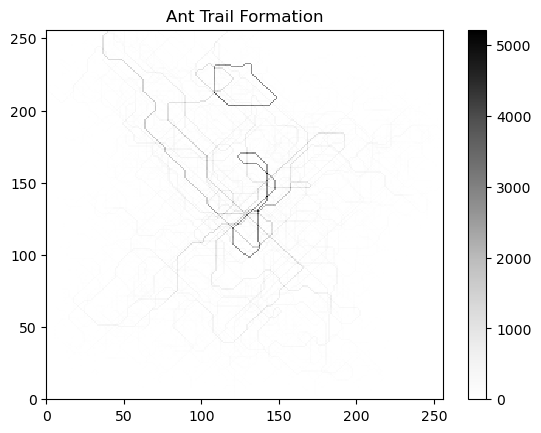

In [42]:
import matplotlib.pyplot as plt

# Initialize grid
grid = Grid(s=256, 
            deposition_rate = 5, 
            evaporation_rate = 1,
            fidelity = 0.6,
            turnProbability = [0.3, 0.3, 0.22, 0.13, 0.05])

# Simulate ant trail formation
for _ in range(1500):
    grid.ant_spawn()
    grid.move()
    
# Visualize grid
fig, ax = plt.subplots()
c = ax.pcolormesh(grid.z, cmap='Greys')
ax.set_title("Ant Trail Formation")
fig.colorbar(c, ax=ax)
fig.patch.set_facecolor('White')
plt.show()